In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from model_utility import plot_images

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.get_logger().setLevel('ERROR')

In [4]:
BASE_DIR = "data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test", "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64

In [5]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2]

In [6]:
EPOCHS = 30
PATIENCE = 5
QUEUE_SIZE = 25
TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PLOTS_DPI = 200

In [7]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    path = os.path.join(TRAIN_DIR, d)
    img_count = len(os.listdir(path))
    total_train += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal training images: {total_train}')

Strawberry___healthy                               : 1824
Grape___Black_rot                                  : 1888
Potato___Early_blight                              : 1939
Blueberry___healthy                                : 1816
Corn_(maize)___healthy                             : 1859
Tomato___Target_Spot                               : 1827
Peach___healthy                                    : 1728
Potato___Late_blight                               : 1939
Tomato___Late_blight                               : 1851
Tomato___Tomato_mosaic_virus                       : 1790
Pepper,_bell___healthy                             : 1988
Orange___Haunglongbing_(Citrus_greening)           : 2010
Tomato___Leaf_Mold                                 : 1882
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 1722
Cherry_(including_sour)___Powdery_mildew           : 1683
Apple___Cedar_apple_rust                           : 1760
Tomato___Bacterial_spot                            : 1702
Grape___health

In [8]:
total_val = 0

for d in os.listdir(VAL_DIR):
    path = os.path.join(VAL_DIR, d)
    img_count = len(os.listdir(path))
    total_val += img_count
    print(f'{d:50} : {img_count}')

print(f'\nTotal validation images: {total_val}')

Strawberry___healthy                               : 456
Grape___Black_rot                                  : 472
Potato___Early_blight                              : 485
Blueberry___healthy                                : 454
Corn_(maize)___healthy                             : 465
Tomato___Target_Spot                               : 457
Peach___healthy                                    : 432
Potato___Late_blight                               : 485
Tomato___Late_blight                               : 463
Tomato___Tomato_mosaic_virus                       : 448
Pepper,_bell___healthy                             : 497
Orange___Haunglongbing_(Citrus_greening)           : 503
Tomato___Leaf_Mold                                 : 470
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         : 430
Cherry_(including_sour)___Powdery_mildew           : 421
Apple___Cedar_apple_rust                           : 440
Tomato___Bacterial_spot                            : 425
Grape___healthy                

In [9]:
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(TEST_DIR):
    img = load_img(os.path.join(TEST_DIR, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)
    print(img_name)
    
test_image_data = np.array(test_image_data)/255
print(f'\nTotal testing images: {len(test_image_data)}')

AppleScab3.JPG
TomatoEarlyBlight2.JPG
TomatoEarlyBlight3.JPG
PotatoHealthy1.JPG
AppleScab2.JPG
TomatoEarlyBlight1.JPG
PotatoHealthy2.JPG
AppleScab1.JPG
TomatoEarlyBlight4.JPG
TomatoEarlyBlight5.JPG
TomatoEarlyBlight6.JPG
PotatoEarlyBlight4.JPG
PotatoEarlyBlight5.JPG
PotatoEarlyBlight2.JPG
PotatoEarlyBlight3.JPG
PotatoEarlyBlight1.JPG
TomatoYellowCurlVirus2.JPG
TomatoYellowCurlVirus3.JPG
TomatoYellowCurlVirus1.JPG
TomatoHealthy4.JPG
TomatoYellowCurlVirus4.JPG
TomatoHealthy1.JPG
TomatoYellowCurlVirus5.JPG
TomatoHealthy3.JPG
TomatoHealthy2.JPG
TomatoYellowCurlVirus6.JPG
AppleCedarRust2.JPG
CornCommonRust1.JPG
AppleCedarRust3.JPG
AppleCedarRust1.JPG
CornCommonRust2.JPG
CornCommonRust3.JPG
AppleCedarRust4.JPG

Total testing images: 33


In [10]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 70295 images belonging to 38 classes.


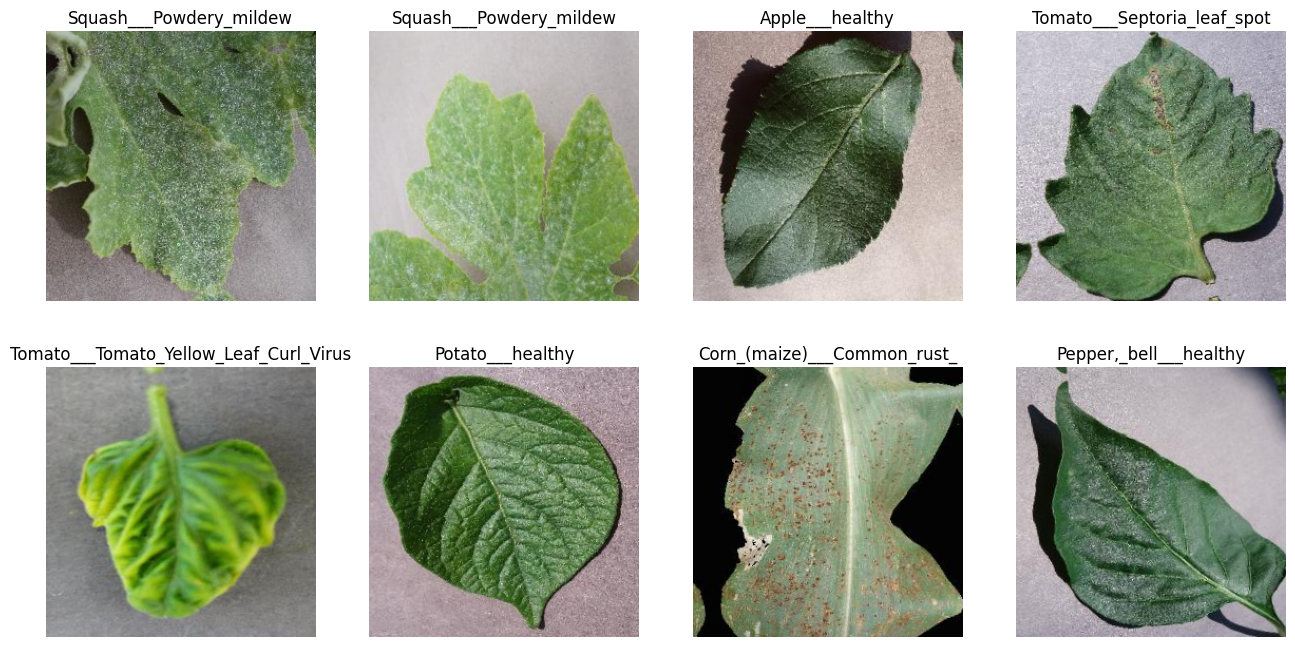

In [11]:
plot_images(train_data_gen)

In [12]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


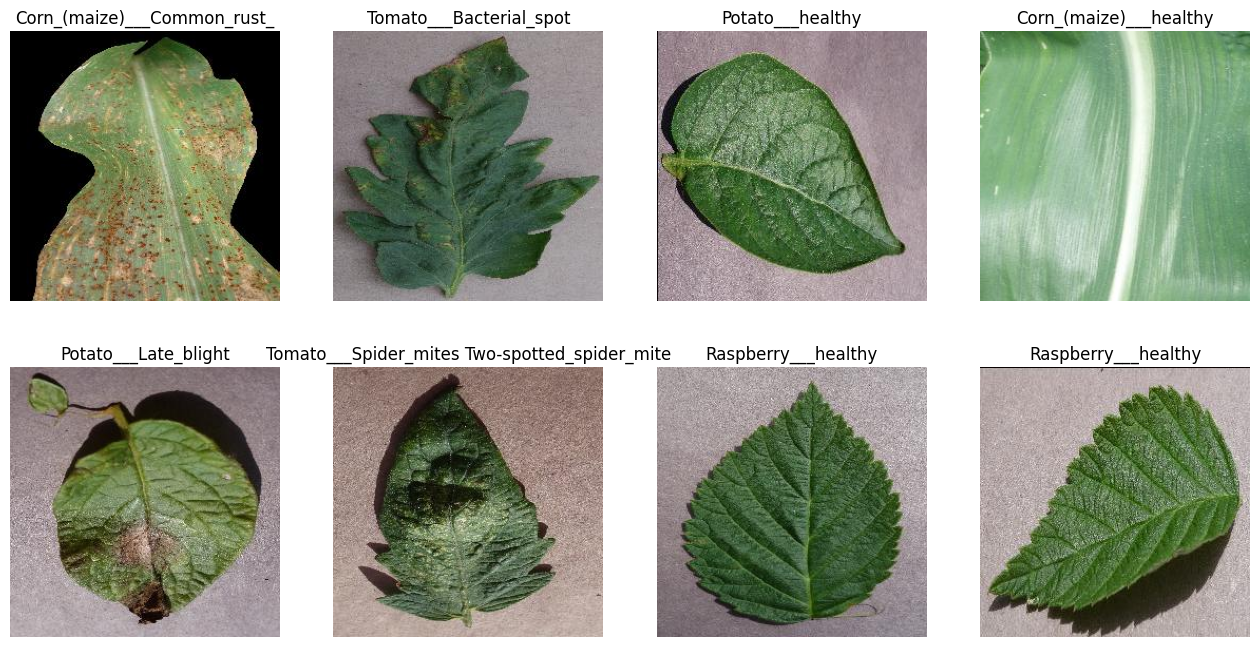

In [13]:
plot_images(val_data_gen)

In [14]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


In [15]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Blueberry___healthy
 5 : Cherry_(including_sour)___Powdery_mildew
 6 : Cherry_(including_sour)___healthy
 7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 8 : Corn_(maize)___Common_rust_
 9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_blight
31 : Tomato___Leaf_Mold
32 : Tomato___Septoria_leaf_spot
33 

In [16]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
inputs.shape

(None, 256, 256, 3)

### Depthwise Convolution + Pointwise Convolution + Max Pooling blocks

#### Block 1

In [17]:
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu", name = "DwC_1")(inputs)
depth_conv_1.shape

2025-04-21 15:43:41.626602: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-21 15:43:41.626749: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-21 15:43:41.626764: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-21 15:43:41.626973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-21 15:43:41.626984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(None, 256, 256, 24)

In [18]:
point_conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu", name = "PwC_1")(depth_conv_1)
point_conv_1.shape

(None, 256, 256, 32)

In [19]:
max_pool_1 = MaxPooling2D(name = "MP_1")(point_conv_1)
max_pool_1.shape

(None, 128, 128, 32)

#### Block 2

In [20]:
depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_2")(max_pool_1)
depth_conv_2.shape

(None, 128, 128, 32)

In [21]:
point_conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu", name = "PwC_2")(depth_conv_2)
point_conv_2.shape

(None, 128, 128, 64)

In [22]:
max_pool_2 = MaxPooling2D(name = "MP_2")(point_conv_2)
max_pool_2.shape

(None, 64, 64, 64)

#### Block 3

In [23]:
depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_3")(max_pool_2)
depth_conv_3.shape

(None, 64, 64, 64)

In [24]:
point_conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu", name = "PwC_3")(depth_conv_3)
point_conv_3.shape

(None, 64, 64, 128)

In [25]:
max_pool_3 = MaxPooling2D(name = "MP_3")(point_conv_3)
max_pool_3.shape

(None, 32, 32, 128)

#### Block 4

In [26]:
depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_4")(max_pool_3)
depth_conv_4.shape

(None, 32, 32, 128)

In [27]:
point_conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu", name = "PwC_4")(depth_conv_4)
point_conv_4.shape

(None, 32, 32, 256)

In [28]:
max_pool_4 = MaxPooling2D(name = "MP_4")(point_conv_4)
max_pool_4.shape

(None, 16, 16, 256)

#### Block 5

In [29]:
depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu", name = "DwC_5")(max_pool_4)
depth_conv_5.shape

(None, 16, 16, 256)

In [30]:
point_conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu", name = "PwC_5")(depth_conv_5)
point_conv_5.shape

(None, 16, 16, 512)

In [31]:
max_pool_5 = MaxPooling2D(name = "MP_5")(point_conv_5)
max_pool_5.shape

(None, 8, 8, 512)

### Global Average Pooling layers for each block

In [32]:
global_avg_1 = GlobalAveragePooling2D(name = "GAP_1")(max_pool_1)
global_avg_1.shape

(None, 32)

In [33]:
global_avg_2 = GlobalAveragePooling2D(name = "GAP_2")(max_pool_2)
global_avg_2.shape

(None, 64)

In [34]:
global_avg_3 = GlobalAveragePooling2D(name = "GAP_3")(max_pool_3)
global_avg_3.shape

(None, 128)

In [35]:
global_avg_4 = GlobalAveragePooling2D(name = "GAP_4")(max_pool_4)
global_avg_4.shape

(None, 256)

In [36]:
global_avg_5 = GlobalAveragePooling2D(name = "GAP_5")(max_pool_5)
global_avg_5.shape

(None, 512)

### Concatenation Layer

In [37]:
concatenated = Concatenate(name = "Concat")([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
concatenated.shape

(None, 992)

### Dropout and Dense Layers

In [38]:
dropout_1 = Dropout(DROPOUT_PERCENTS[0], name = "Droput_1")(concatenated)
dropout_1.shape

(None, 992)

In [39]:
dense_1 = Dense(DENSE_NODES, activation = "relu", name = "Dense_1")(dropout_1)
dense_1.shape

(None, 512)

In [40]:
dropout_2 = Dropout(DROPOUT_PERCENTS[1], name = "Dropout_2")(dense_1)
dropout_2.shape

(None, 512)

In [41]:
dense_2 = Dense(total_classes, activation = "softmax", name = "Output")(dropout_2)
dense_2.shape

(None, 38)

### Model Summary

In [42]:
model = Model(inputs = inputs, outputs = dense_2, name = "Plant_Leaf")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "Plant_Leaf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_1               │ (None, 256, 256,  │        120 │ Input[0][0]       │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_1 (Conv2D)      │ (None, 256, 256,  │        800 │ DwC_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_1 (MaxPooling2D) │ (None, 128, 128,  │          0 │ PwC_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_2               │ (None, 128, 128,  │        160 │ MP_1[0][0]        │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_2 (Conv2D)      │ (None, 128, 128,  │      2,112 │ DwC_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_2 (MaxPooling2D) │ (None, 64, 64,    │          0 │ PwC_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_3               │ (None, 64, 64,    │        320 │ MP_2[0][0]        │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_3 (Conv2D)      │ (None, 64, 64,    │      8,320 │ DwC_3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_3 (MaxPooling2D) │ (None, 32, 32,    │          0 │ PwC_3[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_4               │ (None, 32, 32,    │        640 │ MP_3[0][0]        │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_4 (Conv2D)      │ (None, 32, 32,    │     33,024 │ DwC_4[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_4 (MaxPooling2D) │ (None, 16, 16,    │          0 │ PwC_4[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DwC_5               │ (None, 16, 16,    │      1,280 │ MP_4[0][0]        │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PwC_5 (Conv2D)      │ (None, 16, 16,    │    131,584 │ DwC_5[0][0]       │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MP_5 (MaxPooling2D) │ (None, 8, 8, 512) │          0 │ PwC_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GAP_1               │ (None, 32)        │          0 │ MP_1[0][0]        │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 706,270 (2.69 MB)

 Trainable params: 706,270 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
plot_model(model, to_file = 'plots/model.jpg', show_shapes = True, dpi = PLOTS_DPI)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Training

### Callbacks

In [44]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

### History

In [45]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    callbacks = [earlyStop, tensorBoard]
)

/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-04-21 15:43:43.579428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 789s 715ms/step - accuracy: 0.3430 - loss: 38.3932 - val_accuracy: 0.0874 - val_loss: 4.5622
Epoch 2/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 881s 801ms/step - accuracy: 2.2495 - loss: 11.0651 - val_accuracy: 0.1262 - val_loss: 9.5115
Epoch 3/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 960s 873ms/step - accuracy: 1.7775 - loss: 11.8335 - val_accuracy: 0.2410 - val_loss: 9.3915
Epoch 4/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 808s 734ms/step - accuracy: 0.6970 - loss: 163.6967 - val_accuracy: 0.0748 - val_loss: 23.6423
Epoch 5/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 808s 735ms/step - accuracy: 0.2674 - loss: 372.8970 - val_accuracy: 0.0998 - val_loss: 29.3263
Epoch 6/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 810s 737ms/step - accuracy: 1.2631 - loss: 525.8663 - val_accuracy: 0.1103 - val_loss: 34.3514
CPU times: user 1h 32min 29s, sys: 47min 11s, total: 2h 19min 41s
Wall time: 1h 24min 16s


FileNotFoundError: [Errno 2] No such file or directory: 'plots/acc_and_loss.jpg'

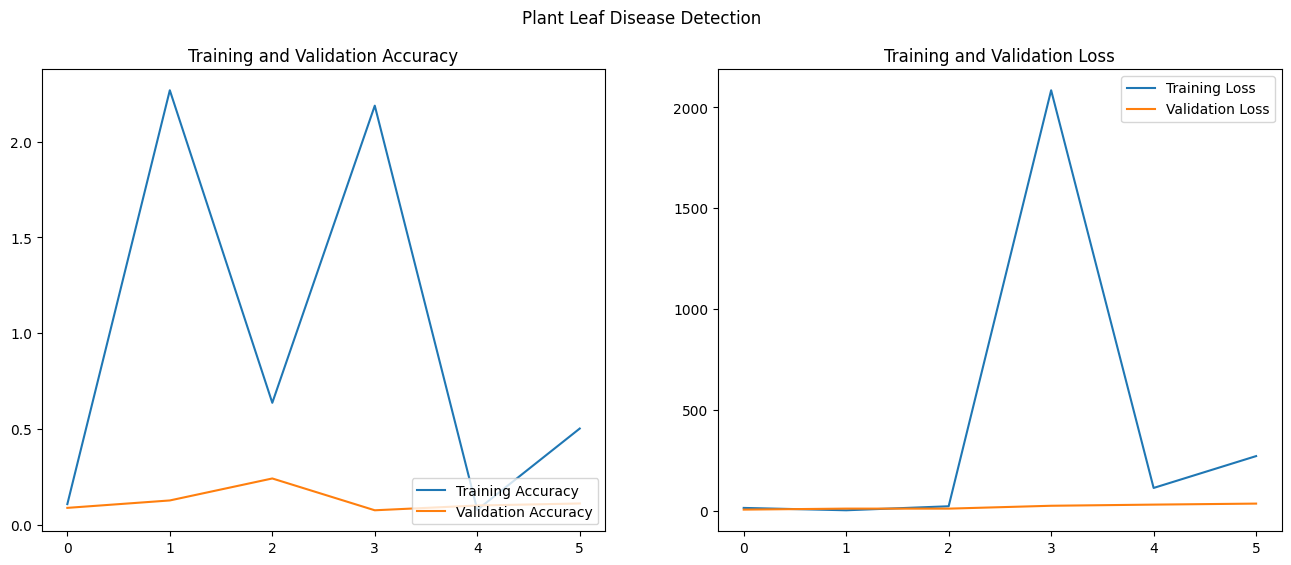

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Plant Leaf Disease Detection')

plt.savefig('plots/acc_and_loss.jpg', dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Evaluation

### Evaluating Test data

In [ ]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)
test_pred

array([ 2,  2,  2,  2, 25,  0, 20,  8,  8,  8, 20, 20, 20, 20, 20, 22, 22,
       29, 29, 29, 29, 29, 29, 37, 37, 37, 37, 35, 35, 35, 35, 35, 35],
      dtype=int64)

In [ ]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

Filename                       Predicted classes
0          AppleCedarRust1.JPG                Apple___Cedar_apple_rust
1          AppleCedarRust2.JPG                Apple___Cedar_apple_rust
2          AppleCedarRust3.JPG                Apple___Cedar_apple_rust
3          AppleCedarRust4.JPG                Apple___Cedar_apple_rust
4               AppleScab1.JPG                 Squash___Powdery_mildew
5               AppleScab2.JPG                      Apple___Apple_scab
6               AppleScab3.JPG                   Potato___Early_blight
7          CornCommonRust1.JPG             Corn_(maize)___Common_rust_
8          CornCommonRust2.JPG             Corn_(maize)___Common_rust_
9          CornCommonRust3.JPG             Corn_(maize)___Common_rust_
10      PotatoEarlyBlight1.JPG                   Potato___Early_blight
11      PotatoEarlyBlight2.JPG                   Potato___Early_blight
12      PotatoEarlyBlight3.JPG                   Potato___Early_blight
13      PotatoEarlyBlight4.JPG                   Potato___Early_blight
14      PotatoEarlyBlight5.JPG                   Potato___Early_blight
15          PotatoHealthy1.JPG                        Potato___healthy
16          PotatoHealthy2.JPG                        Potato___healthy
17      TomatoEarlyBlight1.JPG                   Tomato___Early_blight
18      TomatoEarlyBlight2.JPG                   Tomato___Early_blight
19      TomatoEarlyBlight3.JPG                   Tomato___Early_blight
20      TomatoEarlyBlight4.JPG                   Tomato___Early_blight
21      TomatoEarlyBlight5.JPG                   Tomato___Early_blight
22      TomatoEarlyBlight6.JPG                   Tomato___Early_blight
23          TomatoHealthy1.JPG                        Tomato___healthy
24          TomatoHealthy2.JPG                        Tomato___healthy
25          TomatoHealthy3.JPG                        Tomato___healthy
26          TomatoHealthy4.JPG                        Tomato___healthy
27  TomatoYellowCurlVirus1.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
28  TomatoYellowCurlVirus2.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
29  TomatoYellowCurlVirus3.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
30  TomatoYellowCurlVirus4.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
31  TomatoYellowCurlVirus5.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
32  TomatoYellowCurlVirus6.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus

### Visualizing test data predictions

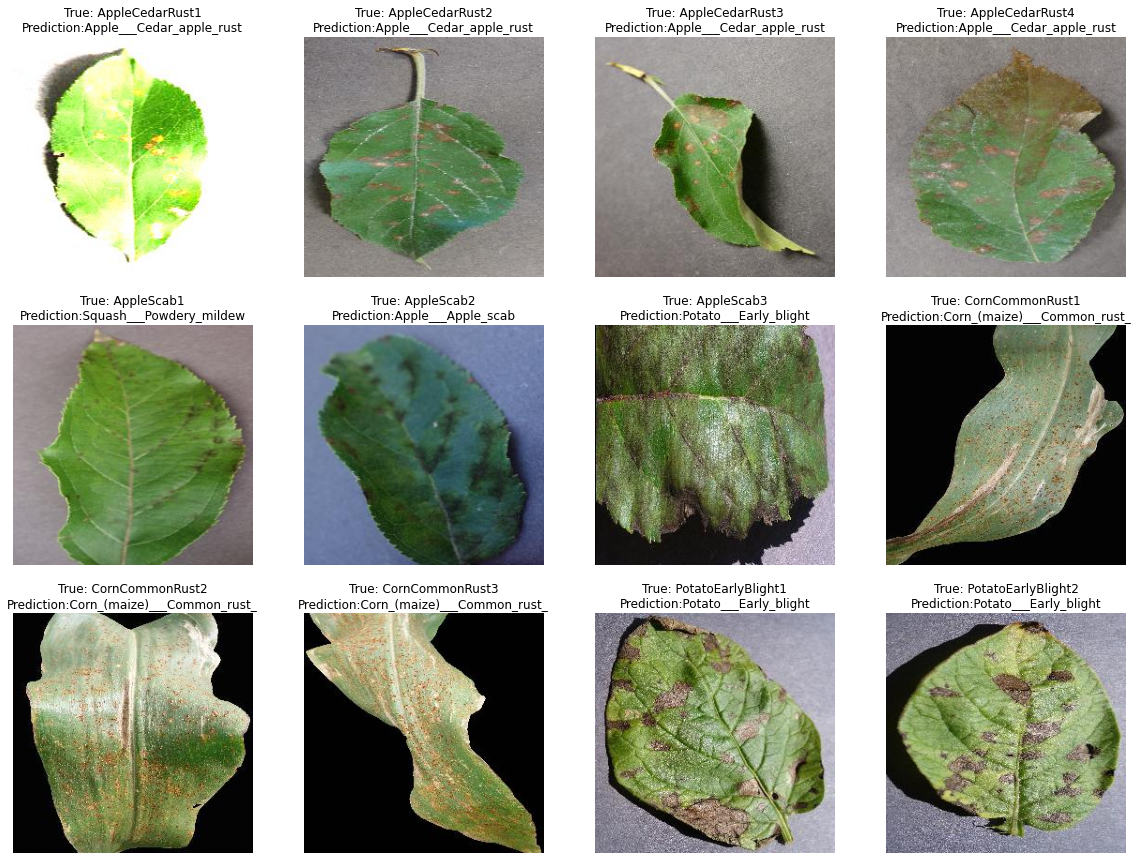

In [ ]:
plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")

plt.show()

### Confusion matrix for validation data

In [ ]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 17572 images belonging to 38 classes.


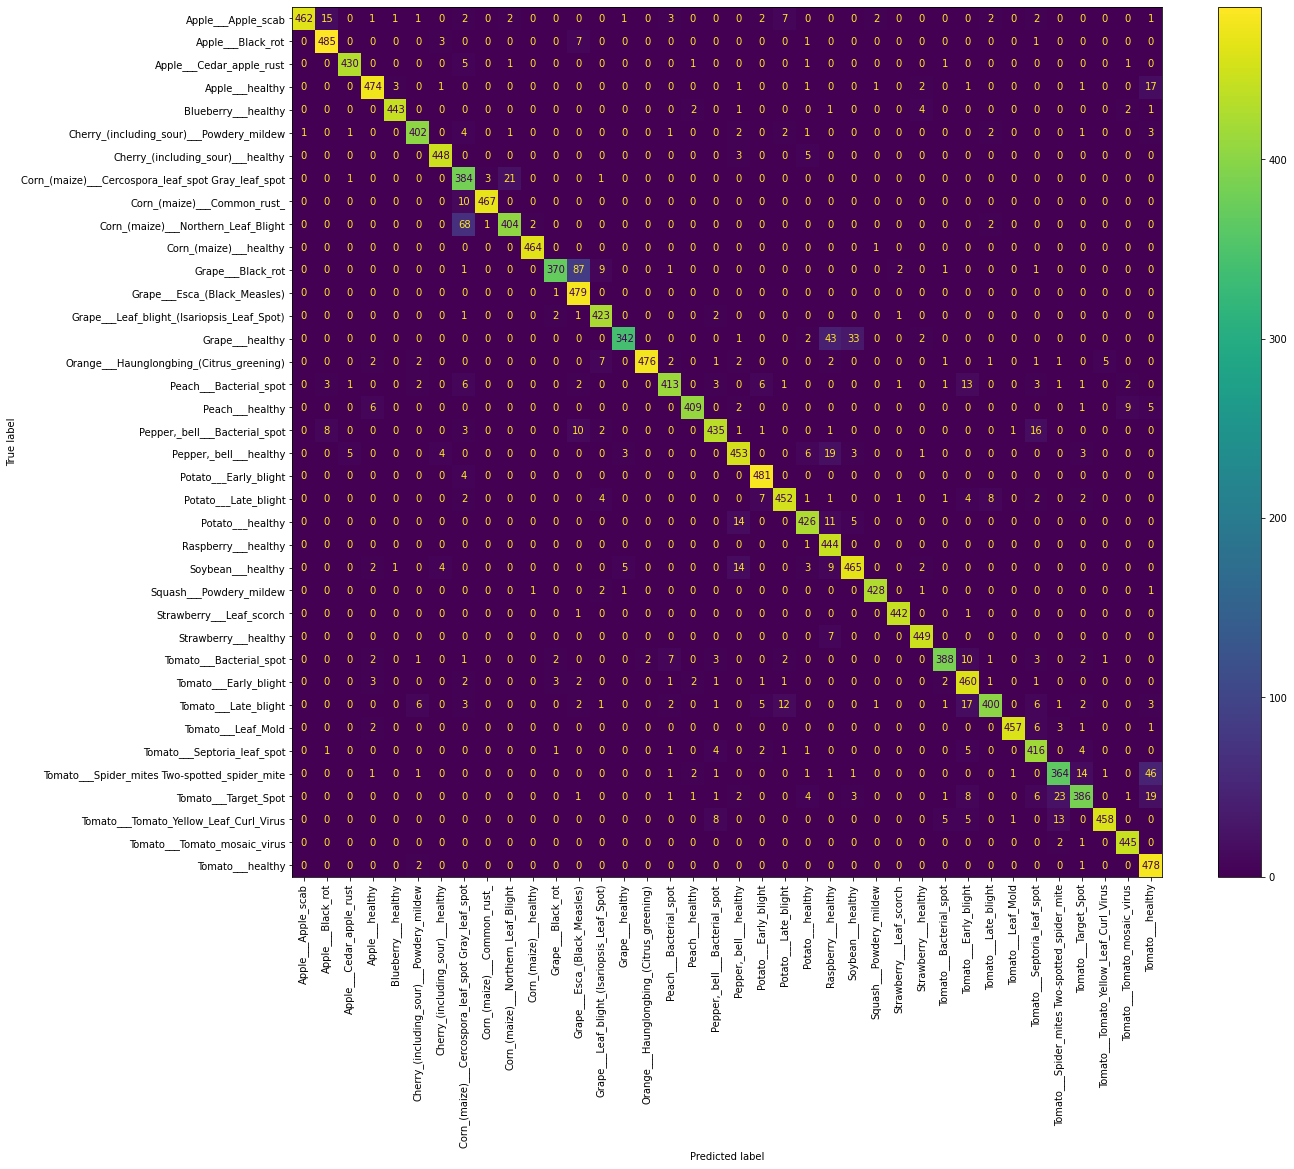

In [ ]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.savefig('plots/confusion_matrix.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Saving the model

In [ ]:
model.save('models/plant_leaf_disease_detector')